# Plot piControl output from simulation using CMIP7 SAD

---

Create date: 2025-08-2819


In [49]:
import yaml
import iris
import xarray as xr
from ncdata.iris_xarray import cubes_to_xarray
import sys
import matplotlib.pyplot as plt

# modules from this directory
sys.path.append("../../")
from src.util.STASH_fields_defs import UKCA_callback
import src.const as CONST


# from src.util.load_data import *

In [50]:
# Load config
with open("config.yaml") as f:
    config = yaml.safe_load(f)

In [51]:
def generate_dataset_file_paths(
    data_root_dir: str, dataset_suites: dict[str, str], stashes: list[str]
):
    """
    Create dictionary of lists of file paths for each suite.

    Parameters
    ----------
    data_root_dir : str
        Root directory where data is stored.
    dataset_suites : dict of str
        Mapping of dataset names to Rose suite IDs. e.g. u-ab123
    stashes : list of str
        List of stash items. e.g. 50001

    Returns
    -------
    dict of str to list of str
        Dictionary mapping dataset names to lists of file paths.

    """
    paths = {}
    for exp, suite in dataset_suites.items():
        paths[exp] = [f"{data_root_dir}/{suite}_apy.pp_{v}/*.pp" for v in stashes]
    return paths

In [52]:
def load_xr_from_pp(
    paths: list[str],
    rename_coords: bool = False,
    rename_dict: dict = None,
):
    """
    Load a list of PP files into an xarray.Dataset .

    Parameters
    ----------
    paths : list of str
        List of file paths to load. May contain wildcard (*)
    rename_coords : bool, optional
        If True, rename coordinates using `rename_dict`. Default is False.
    rename_dict : dict, optional
        Dictionary mapping original coordinate names to new names. If None and renaming is requested,
        a default mapping for 'latitude', 'longitude', and 'model_level_number' is used.

    Returns
    -------
    xarray.Dataset
        The loaded dataset with coordinates optionally renamed.
    """

    # Check if paths is set
    if not paths:
        raise FileNotFoundError("No file paths provided to load_xr_from_pp.")

    # ensure dataset-level and variable-level attributes loaded correctly
    iris.FUTURE.save_split_attrs = True

    iris_cube = iris.load(paths, callback=UKCA_callback)

    ds = cubes_to_xarray(iris_cube)
    if rename_coords:
        if rename_dict is None:
            rename_dict = {
                "latitude": "lat",
                "longitude": "lon",
                "model_level_number": "lev",
            }

        ds = ds.rename(rename_dict)

    return ds


def load_multiple_exps(
    config: dict,
    exp_subset: list[str] = None,
    stashes_subset: list[str] = None,
    rename_coords: bool = False,
    input_type: str = "pp",
    loaded_as: str = "xarray",
):
    """
    Load multiple experiments' datasets from pp files as xarray objects based on configuration and optional subsets.

    Parameters
    ----------
    config : dict
        Configuration dictionary containing 'dataset_suites', 'stashes', and 'pp_root_dir'.
    exp_subset : list of str, optional
        List of experiment keys to load. If None, all experiments in config['dataset_suites'] are loaded.
    stashes_subset : list of str, optional
        List of stash codes to load. If None, all stashes in config['stashes'] are loaded.
    rename_coords : bool, optional
        If True, rename coordinates using `rename_dict`. Default is False.
    Returns
    -------
    dict of str to xarray.Dataset
        Dictionary mapping experiment names to loaded xarray datasets.
    """

    if exp_subset is None:
        datasets_load = config["dataset_suites"]
    else:
        datasets_load = {
            exp: config["dataset_suites"][exp]["rose-suite"]
            for exp in exp_subset
            if exp in config["dataset_suites"]
        }

    if stashes_subset is None:
        stashes_load = config["stashes"]
    else:
        stashes_load = stashes_subset

    dataset_paths = generate_dataset_file_paths(
        data_root_dir=config["pp_root_dir"],
        dataset_suites=datasets_load,
        stashes=stashes_load,
    )

    if input_type == "pp" and loaded_as == "xarray":
        datasets = {
            exp: load_xr_from_pp(paths, rename_coords=rename_coords)
            for exp, paths in dataset_paths.items()
        }

    return datasets

## Load data


In [53]:
# Subset of values to load
exp_subset = [
    "e1.3-piControl-cmip7-sad7",
]

stashes_subset = ["34001", "34966"]

datasets = load_multiple_exps(config, exp_subset, stashes_subset, rename_coords=True)

/home/users/vs480/.conda/envs/cmip6-env/lib/python3.9/site-packages/iris/fileformats/rules.py:338: IrisUserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(


## Plot aerosol surface area density


In [54]:
def create_custom_subplots(
    fig_width, widths_subplot, heights_subplot, exclude_bottom_rows: int = 0
):

    fig = plt.figure(figsize=(fig_width, 0.5 * fig_width))

    nrow = len(heights_subplot)
    ncol = len(widths_subplot)

    gs = fig.add_gridspec(
        nrow, ncol, width_ratios=widths_subplot, height_ratios=heights_subplot
    )

    if nrow - exclude_bottom_rows < 0:
        raise ValueError("nrow < 0")

    axs = [
        fig.add_subplot(gs[i, j])
        for i in range(nrow - exclude_bottom_rows)
        for j in range(ncol)
    ]

    return fig, axs, gs, nrow, ncol

In [55]:
zonal_mean_ppb = {e: xr.Dataset() for e in datasets.keys()}

molar_masses = {
    "o3": CONST.M_O3,
}

for exp in zonal_mean_ppb.keys():
    print(exp)
    for species in ["o3"]:
        zonal_mean_ppb[exp][species] = (
            datasets[exp][species]
            .sel(time=slice("1865-01-01", "1895-01-01"))  # after spin-up
            .mean(dim=["lon", "time"])
            .load()
            / molar_masses[species]
            * CONST.M_AIR
            * 1e9
        )

e1.3-piControl-cmip7-sad7
o3


Text(0.5, 1.0, 'Mean aerosol surface area density (1850-2021)')

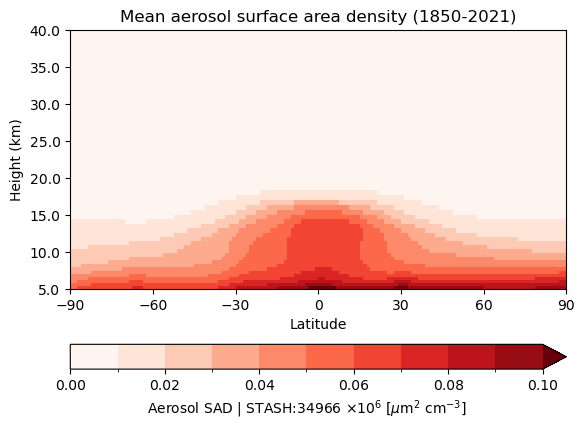

In [62]:
fig, ax = plt.subplots()
plot_data = (
    datasets["e1.3-piControl-cmip7-sad7"]["aerosol_sa_density"]
    .isel(time=-1)
    .mean(dim="lon")
    * 1e6
)

plot_data.plot(
    ax=ax,
    x="lat",
    y="level_height",
    cmap=plt.cm.Reds,
    vmin=0,
    vmax=0.1,
    levels=11,
    extend="max",
    cbar_kwargs={
        "orientation": "horizontal",
        "label": "Aerosol SAD | STASH:34966 $\\times 10^6$ [$\mu$m$^2$ cm$^{-3}$]",
    },
)

ax.set_xticks(range(-90, 91, 30))
ax.set_xlabel("Latitude")
ax.set_yticks(range(0, 40001, 5000))
ax.set_ylim(5000, 40000)
ax.set_yticklabels([i / 1000 for i in ax.get_yticks()])
ax.set_ylabel("Height (km)")
ax.set_title("Mean aerosol surface area density (1850-2021)")